In [1]:
from experiments.partial import build_partial, plot_partial
from lafomo.datasets import DrosophilaSpatialTranscriptomics, ToySpatialTranscriptomics
from lafomo.models import MultiOutputGP
from lafomo.plot import plot_spatiotemporal_data
from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
# dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
dataset = ToySpatialTranscriptomics(data_dir='../../../data')
data = 'dros-kr'
data = 'toy-spatial'
params = dict(lengthscale=10,
              sensitivity=0.1,
              decay=0.05,
              diffusion=0.001,
              natural=True,
              clamp=True)
params = dict(lengthscale=0.3,
              sensitivity=1,
              decay=0.1,
              diffusion=0.01,
              natural=False,
              clamp=False)
lfm, trainer, plotter = build_partial(
    dataset,
    params)
    # reload=f'../../../experiments/{data}/partial/0savedmodel')

t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025
x dp is set to 0.025
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025


In [3]:
# data = next(iter(trainer.data_loader))
# t = data[0][0]
# y = data[1][0]
# print(y.shape, t.shape)

In [4]:
from torchcubicspline import(natural_cubic_spline_coeffs,
                             NaturalCubicSpline)

def calc(N, d):
    return (N - 1) * (d + 1) + 1

def spline_interpolate_gradient(x, y, num_disc=9):
    """
    Returns x_interpolate, y_interpolate, y_grad, y_grad_2: the interpolated time, data and gradient
    """
    x_interpolate = torch.linspace(torch.min(x), torch.max(x), calc(x.shape[0], num_disc))
    coeffs = natural_cubic_spline_coeffs(x, y)
    spline = NaturalCubicSpline(coeffs)
    y_interpolate = spline.evaluate(x_interpolate)
    y_grad = spline.derivative(x_interpolate) #y_interpolate, denom, axis=1)
    y_grad_2 = spline.derivative(x_interpolate, order=2)
    return x_interpolate, y_interpolate, y_grad, y_grad_2

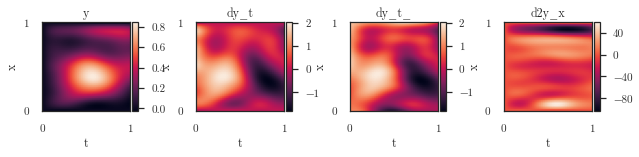

In [50]:
tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]

y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t, num_x)

dy_t = list()
for i in range(num_t):
    t = tx[0][::num_t]
    y = y_matrix[:, i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, _ = \
        spline_interpolate_gradient(t, y)
    dy_t.append(y_grad)
dy_t = torch.stack(dy_t)

d2y_x = list()
dy_x = list()
for i in range(num_x):
    t = tx[1][:num_x]
    y = y_matrix[i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, y_grad_2 = \
        spline_interpolate_gradient(t, y)
    d2y_x.append(y_grad_2)
    dy_x.append(y_grad)

d2y_x = torch.stack(d2y_x)
dy_x = torch.stack(dy_x)[..., ::10, 0].reshape(1, -1)
d2y_x = d2y_x[..., ::10, 0].reshape(1, -1)
dy_t = dy_t[..., ::10, 0].t().reshape(1, -1)
y_grad_target = dy_t

def pde_func(y, u, sensitivity, decay, diffusion):
    # y (1, 1681) u (25, 1, 41, 41) s (25, 1)
    dy_t = (sensitivity * u.view(u.shape[0], -1) -
            decay * y.view(1, -1) +
            diffusion * d2y_x)
    return dy_t

dy_t_ = pde_func(
    trainer.y_target,
    torch.tensor(dataset.orig_data[trainer.t_sorted,2]).unsqueeze(0).repeat(25, 1),
    torch.tensor(1.).unsqueeze(0).repeat(25, 1),
    torch.tensor(0.1).unsqueeze(0).repeat(25, 1),
    torch.tensor(0.01).unsqueeze(0).repeat(25, 1))[0]

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t, num_x).t(),
        dy_t.reshape(num_t, num_x).t(),
        dy_t_.view(num_t, num_x).t(),
        d2y_x.view(num_t, num_x).t()
    ],
    extent, titles=['y', 'dy_t', 'dy_t_', 'd2y_x']
)

output torch.Size([1681, 1]) torch.Size([1681, 1])
Mean output variance: 0.02489226272266071
Test loss: 1.3770807407048096
Q2: -13.091
Epoch 031/040 - Loss: 0.31 (0.17 0.14) kernel: [[[0.29123103 0.27297863]]] s: 0.5039011574319152 dec: 0.02592089363849022 diff: 0.0015590955858047842
output torch.Size([1681, 1]) torch.Size([1681, 1])
Mean output variance: 0.02634858877532807
Test loss: 1.4683417545204447
Q2: -12.722
Epoch 032/040 - Loss: 0.37 (0.17 0.20) kernel: [[[0.28432009 0.25984726]]] s: 0.507559815997126 dec: 0.02544315369440931 diff: 0.0015002721712564526
output torch.Size([1681, 1]) torch.Size([1681, 1])
Mean output variance: 0.029375181796415246
Test loss: 1.5809034803439606
Q2: -13.009
Epoch 033/040 - Loss: 0.39 (0.16 0.24) kernel: [[[0.27627112 0.25017548]]] s: 0.5110686387524788 dec: 0.025016405003561826 diff: 0.0014472738034612407
output torch.Size([1681, 1]) torch.Size([1681, 1])
Mean output variance: 0.029299729336168485
Test loss: 1.6571843366849073
Q2: -13.720
Epoch 03

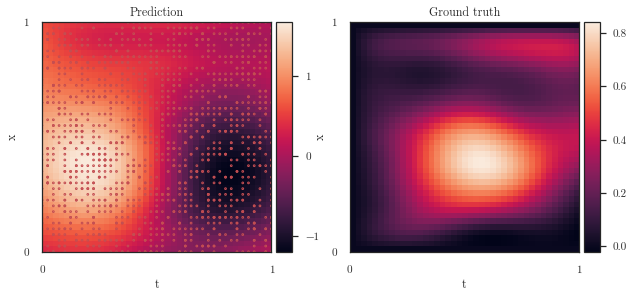

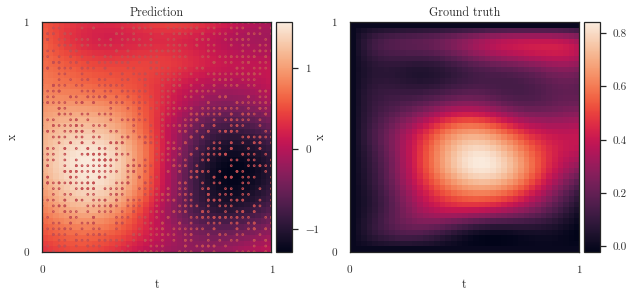

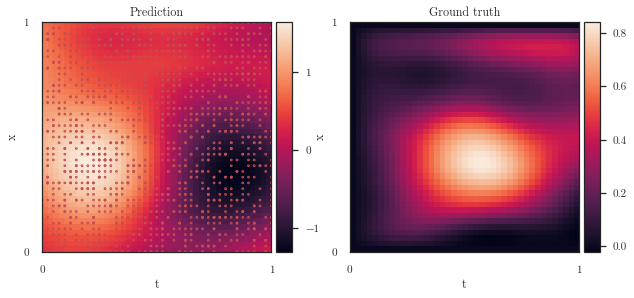

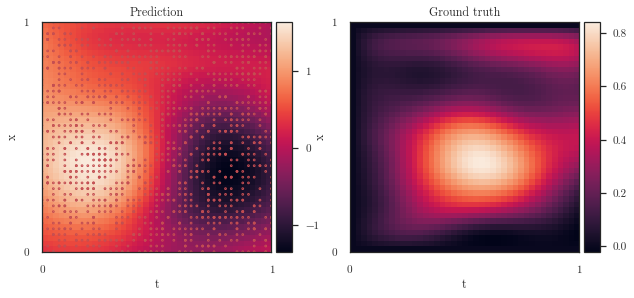

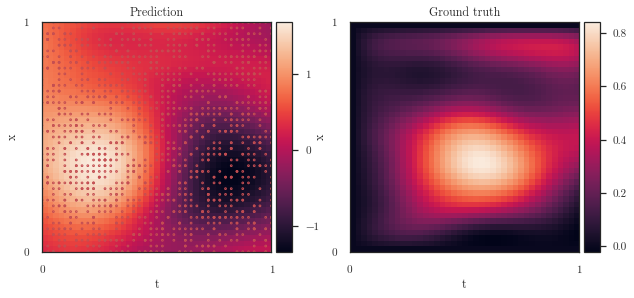

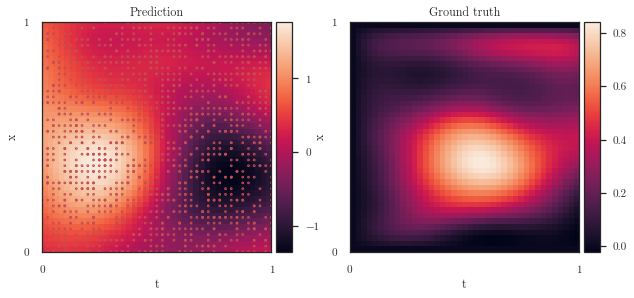

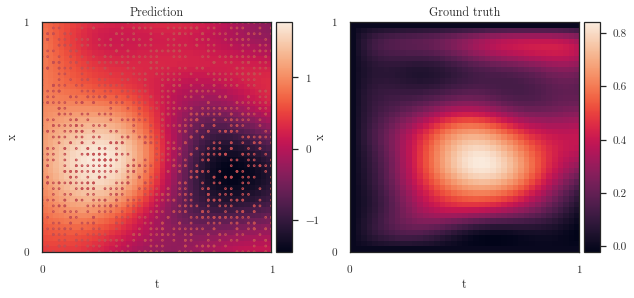

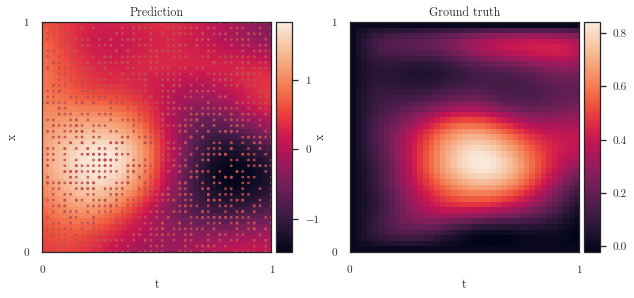

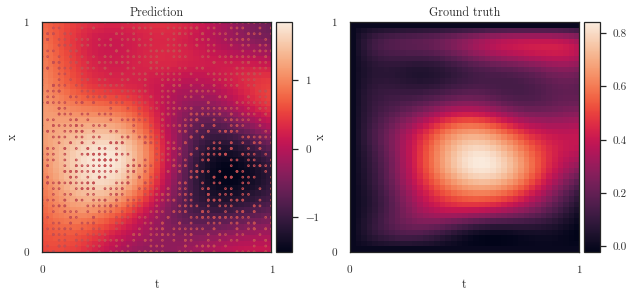

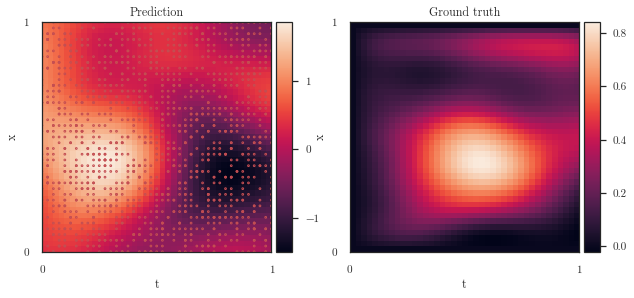

In [55]:
lfm.pretrain(True)
trainer.train(10, pretrain_target=y_grad_target, pde_func=pde_func)

In [7]:
lfm.pretrain(False)
trainer.train(10)

TypeError: can't pickle dolfin.cpp.mesh.Mesh objects

In [ ]:
lfm.variational_parameters()

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(dict(lfm.named_parameters())['gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_tril_mat'][0].detach())
plt.colorbar()

In [ ]:
from lafomo.utilities.torch import softplus
print(list(map(softplus, lfm.fenics_parameters)))

In [52]:
from pathlib import Path
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

TypeError: can't pickle dolfin.cpp.mesh.Mesh objects

In [ ]:
from lafomo.plot import plot_spatiotemporal_data
lfm.eval()
f = lfm(tx)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

# print(dataset.orig_data[:, 2])
l_target = torch.tensor(dataset.orig_data[:, 2])
l = lfm.gp_model(tx.t())
l_mean = l.mean.detach()
# plt.imshow(l_mean.view(num_t, num_x).transpose(0, 1))
print(l_mean.shape)
plot_spatiotemporal_data(
    [
        f_mean.view(num_t, num_x).t(),
        y_target.view(num_t, num_x).detach().t(),

        l_mean.view(num_t, num_x).t(),
        l_target.view(num_t, num_x).t()
    ],
    extent,
    titles=None
)
plt.gca().get_figure().set_size_inches(15, 7)

In [ ]:
import torch
fig, ax = plt.subplots()
ax.imshow(torch.randn(10, 10))
ax.grid()
print(ax)